Análise exploratória dos arquivos de log.
Leitura do arquivo .log extraindo os atributos e transformando na representação pandas para análise dos atributos.

In [1]:
import re
import pandas as pd
import numpy as np

Carregar o arquivo de dados: acccess.log e armazenar num dataframe.
Imprimir algumas linhas deste arquivo. Verificar os tipos dos atributos desta base de dados.

In [3]:
# Defina o padrão do log usando regex
log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<data>.*?)\] "(?P<metodo>\w+) (?P<url>\S+) HTTP/\d\.\d" (?P<status>\d{3}) (?P<tamanho>\d+|-) "(?P<referencia>.*?)" "(?P<agente>.*?)"'

# Carregue o arquivo
log_file = 'logs-invasao.log'

# Parse as linhas e armazene em uma lista
entries = []
with open(log_file, 'r') as file:
    for line in file:
        match = re.match(log_pattern, line)
        if match:
            entries.append(match.groupdict())

# Transforme em DataFrame para análise
df = pd.DataFrame(entries)

# Convertendo campos para os tipos corretos
df['tamanho'] = pd.to_numeric(df['tamanho'], errors='coerce')
df['data'] = pd.to_datetime(df['data'], format='%d/%b/%Y:%H:%M:%S %z')
df['status'] = df['status'].astype(int)
# Cria colunas separadas para data e hora (mantém o datetime original em 'data')
df['dia'] = df['data'].dt.date         # Apenas a data (ex: 2025-05-10)
df['hora'] = df['data'].dt.time        # Apenas a hora completa (ex: 14:32:08)
df['hora_decimal'] = df['data'].dt.hour + df['data'].dt.minute / 60  # Hora como número (útil para gráficos)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   ip            4851 non-null   object                   
 1   data          4851 non-null   datetime64[ns, UTC-03:00]
 2   metodo        4851 non-null   object                   
 3   url           4851 non-null   object                   
 4   status        4851 non-null   int64                    
 5   tamanho       4851 non-null   int64                    
 6   referencia    4851 non-null   object                   
 7   agente        4851 non-null   object                   
 8   dia           4851 non-null   object                   
 9   hora          4851 non-null   object                   
 10  hora_decimal  4851 non-null   float64                  
dtypes: datetime64[ns, UTC-03:00](1), float64(1), int64(2), object(7)
memory usage: 417.0+ KB


In [5]:
df.head()

,ip,data,metodo,url,status,tamanho,referencia,agente,dia,hora,hora_decimal
0,170.64.164.200,2025-05-10 07:36:04-03:00,GET,/.env,404,8136,-,Mozilla/5.0; Keydrop.io/1.0(onlyscans.com/about);,2025-05-10,07:36:04,7.60
1,170.64.164.200,2025-05-10 07:36:05-03:00,GET,/,400,0,-,-,2025-05-10,07:36:05,7.60
2,170.64.164.200,2025-05-10 07:36:06-03:00,GET,/.git/config,404,8136,-,Mozilla/5.0; Keydrop.io/1.0(onlyscans.com/about);,2025-05-10,07:36:06,7.60
3,170.64.164.200,2025-05-10 07:36:07-03:00,GET,/,400,0,-,-,2025-05-10,07:36:07,7.60
4,18.222.24.23,2025-05-10 07:45:24-03:00,GET,/mbe/images/imagens/pagina/pontos.jpg,200,230945,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",2025-05-10,07:45:24,7.75


In [6]:
import networkx as nx
from collections import defaultdict
import community as community_louvain  # python-louvain
import matplotlib.pyplot as plt

df_erro = df[df['status'].isin([200, 404])]

# Criar um grafo bipartido IP <-> status
B = nx.Graph()
ips = df_erro['ip'].unique()
status_codes = df_erro['status'].unique()

# Adiciona nós com atributos de tipo (para visualização futura)
B.add_nodes_from(ips, bipartite='ip')
B.add_nodes_from(status_codes, bipartite='status')

# Adiciona arestas entre IPs e status que eles geraram
for _, row in df_erro.iterrows():
    B.add_edge(row['ip'], row['status'])

# Agora projetamos o grafo bipartido para grafo só de IPs com pesos baseados em conexões comuns
from networkx.algorithms import bipartite

# Gera projeção do grafo bipartido para o conjunto dos IPs
G = bipartite.weighted_projected_graph(B, ips)

In [7]:
# Aplica a detecção de comunidades de Louvain
partition = community_louvain.best_partition(G, weight='weight')

# Adiciona a informação de cluster (comunidade) aos nós
for node, cluster_id in partition.items():
    G.nodes[node]['cluster'] = cluster_id

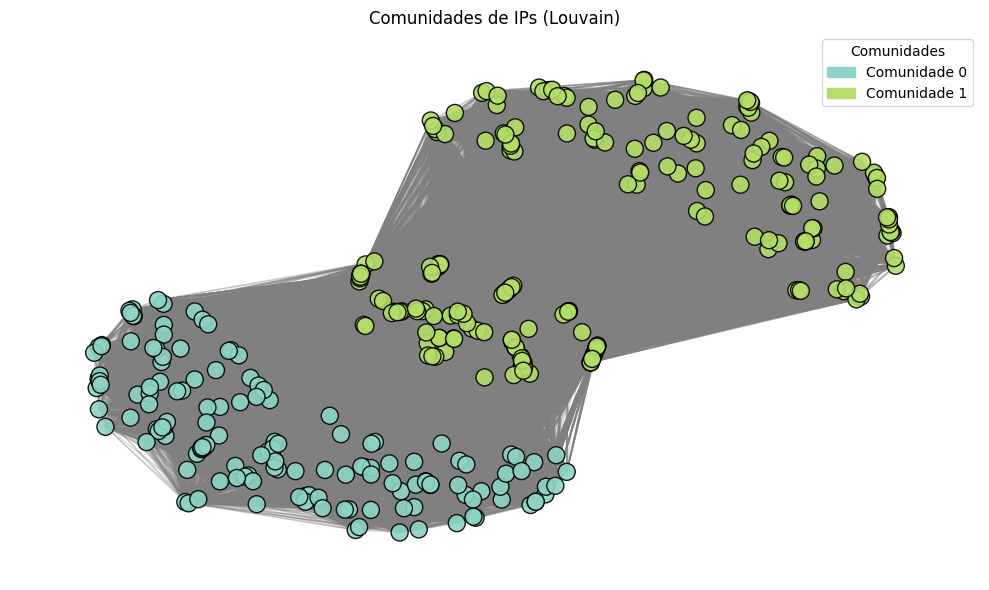

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

plt.figure(figsize=(10, 6))

# Usar a mesma posição
pos = nx.spring_layout(G, seed=42)

# Configurar cores
num_clusters = max(partition.values()) + 1
cmap = plt.colormaps['Set3']
colors = [cmap(i / num_clusters) for i in range(num_clusters)]
node_colors = [colors[partition[node]] for node in G.nodes()]

# Desenhar nós com bordas pretas e tamanho maior
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=150,
    node_color=node_colors,
    edgecolors="black",
    linewidths=1.0,
    alpha=0.9
)

# Arestas mais transparentes
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')

# Opcional: Adicionar rótulos dos nós se quiser
#nx.draw_networkx_labels(G, pos, font_size=6)

# Legenda
legenda = [
    mpatches.Patch(color=colors[i], label=f'Comunidade {i}')
    for i in range(num_clusters)
]
plt.legend(handles=legenda, title="Comunidades", loc="best", fontsize="medium")

plt.title("Comunidades de IPs (Louvain)")
plt.axis("off")
plt.tight_layout()
plt.show()

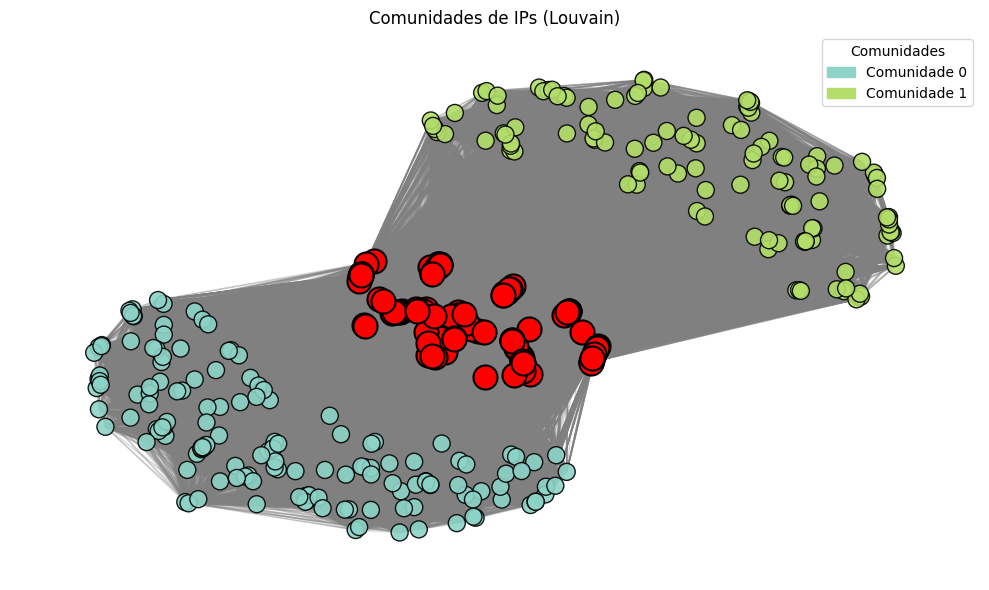

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 6))

# Usar a mesma posição
pos = nx.spring_layout(G, seed=42)

# Configurar cores
num_clusters = max(partition.values()) + 1
#cmap = plt.colormaps['tab20']
cmap = plt.colormaps['Set3']
colors = [cmap(i / num_clusters) for i in range(num_clusters)]
node_colors = [colors[partition[node]] for node in G.nodes()]

# Calcula degree centrality
degree_centrality = nx.degree_centrality(G)
# Calcula betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Organiza tudo num DataFrame
data = []
for node in G.nodes():
    data.append({
        "IP": node,
        "Cluster": partition[node],
        "DegreeCentrality": degree_centrality[node],
        "BetweennessCentrality": betweenness_centrality[node]
    })
df_metrics = pd.DataFrame(data)
threshold = df_metrics["BetweennessCentrality"].quantile(0.90)
df_high_degree = df_metrics[df_metrics["BetweennessCentrality"] >= threshold]
high_degree_ips = set(df_high_degree["IP"])

# Desenhar nós com bordas pretas e tamanho maior
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=150,
    node_color=node_colors,
    edgecolors="black",
    linewidths=1.0,
    alpha=0.9
)
# Sobrepor os nós de alta centralidade em vermelho
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=high_degree_ips,
    node_color="red",
    node_size=300,  # maior que os outros
    edgecolors="black",
    linewidths=1.5,
    alpha=1.0
)

# Arestas mais transparentes
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')

# Opcional: Adicionar rótulos dos nós se quiser
#nx.draw_networkx_labels(G, pos, font_size=6)

# Legenda
legenda = [
    mpatches.Patch(color=colors[i], label=f'Comunidade {i}')
    for i in range(num_clusters)
]
plt.legend(handles=legenda, title="Comunidades", loc="best", fontsize="medium")

plt.title("Comunidades de IPs (Louvain)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
num_comunidades = len(set(partition.values()))
print(f"Total de comunidades detectadas: {num_comunidades}")


Total de comunidades detectadas: 2


In [11]:
from collections import defaultdict

# Agrupa IPs por id de comunidade
clusters = defaultdict(list)
for ip, cluster_id in partition.items():
    clusters[cluster_id].append(ip)

for cluster_id, ip_list in clusters.items():
    print(f"\n🔹 Comunidade {cluster_id} ({len(ip_list)} IPs):")
    for ip in ip_list[:3]:  # Mostra os 10 primeiros IPs de cada grupo
        print(f"  {ip}")



🔹 Comunidade 1 (242 IPs):
  170.64.164.200
  64.124.8.222
  40.77.167.116

🔹 Comunidade 0 (149 IPs):
  18.222.24.23
  165.154.10.187
  123.58.215.102


In [12]:
for cluster_id, ip_list in clusters.items():
    print(f"Comunidade {cluster_id} tem {len(ip_list)} IPs")


Comunidade 1 tem 242 IPs
Comunidade 0 tem 149 IPs
